# Twitter sentiment analysis of Zoom drinking parties

Here, we analyse the sentiment of tweets that allude to drinking parties on Zoom. 
This emerged as a new trend during April, after imposition of lock down measures (quarantine) in many countries as a response to the COVID-19 pandemic.

This analysis is a part of our larger glimpse into alcohol & drug policy in India.

## Mis En Place

### Make the notebook interactive

In [238]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Import necessary modules

In [239]:
import tweepy
from textblob import TextBlob
import sys
import os
import csv

### Twitter authentication

In [240]:
class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"
    
class Credentials:
    consumer_key = "substitute_with_your_twitter_credentials"
    consumer_key_secret = "substitute_with_your_twitter_credentials"

In [241]:
auth = tweepy.AppAuthHandler(Credentials.consumer_key, Credentials.consumer_key_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## Get tweets

### Lookup Twitter

Run the below code to retrieve new tweets.
A corpus of 1123 tweets has been amassed by iterating this code multiple times.

In [242]:
# Focus only on zoom parties involving alcohol
searchQuery = "zoom party (alcohol OR beer OR cocktail OR drink) -makeup -sex -slumber -birthday -bday"

maxTweets = 1000 # Some arbitrary large number
tweetsPerQry = 100  # this is the max the API permits

# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

places = []
time = []
tweets = []

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))

while tweetCount < maxTweets:
    try:
        if (max_id <= 0):
            new_tweets = api.search(q=searchQuery, count=tweetsPerQry)
        else:
            new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        max_id=str(max_id - 1))
        if not new_tweets:
            print("No more tweets found")
            break
            
        for tweet in new_tweets:
            #1. Month, Year of creation
            time.append((tweet.created_at.month,tweet.created_at.year))
            #2. Location of user
            places.append(tweet.user.location)
            # Text of tweet
            tweets.append(tweet.text)

        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id

    except tweepy.TweepError as e:
        # Just exit if any error
        print("some error : " + str(e))
        break

print ("Downloaded {0} tweets".format(tweetCount))

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 523 tweets
No more tweets found
Downloaded 523 tweets


### Save tweets to file

In [243]:
csv_rows = []
for (text, time, place) in zip(tweets, time, places):
    csv_rows.append([time, place, text])
    
tweet_sentiment_file = 'tweets.csv'
with open(tweet_sentiment_file, 'a+', newline='', encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerows(csv_rows)
    
f"{len(csv_rows)} Tweets written into file {tweet_sentiment_file}"


'523 Tweets written into file tweets_2.csv'

## Clean up tweets

### Load the saved tweets file

In [258]:
import pandas as pd

tweets_file = 'tweets.csv'
# Load the file into a pandas data frame with meaningful column names, as the csv file didn't have headers.
tweets = pd.read_csv(tweets_file, names = ['time', 'place', 'text'])

tweets.head()
len(tweets)

,time,place,text
0,"(4, 2020)","15 Yemen Road, Yemen",@svndygirl I.....I want to party more go to th...
1,"(4, 2020)",NaN,RT @OfficialBrianaB: Friends! My girl @_Waywar...
2,"(4, 2020)","Washington, DC",@CaitlinOrKitty @KyleFieldsHere @MotherVoter @...
3,"(4, 2020)",Japan,RT @OfficialBrianaB: Friends! My girl @_Waywar...
4,"(4, 2020)",NaN,Idk why I didn't think of this sooner.. I shou...


1123

### Remove special characters & URLs

In [245]:
import re
import nltk
from nltk.corpus import stopwords

# Remove strings starting with @, strings starting with #, URLs, or "RT"
def clean_tweet(x):
    cleaned = []
    for word in x.split():
        word = re.sub(r'@\S+', "", word)
        word = re.sub(r'#\S+', "", word)
        word = re.sub(r'https?:\/\/\S+',"", word)
        word = re.sub(r'[RT]', "", word)
        cleaned.append(word)
    return " ".join(cleaned)

tweets['text'] = tweets['text'].apply(clean_tweet)
tweets.head()

,time,place,text
0,"(4, 2020)","15 Yemen Road, Yemen",I.....I want to party more go to the beach at...
1,"(4, 2020)",NaN,Friends! My girl is hosting he Happy Hour a...
2,"(4, 2020)","Washington, DC",he fact that the beer ca…
3,"(4, 2020)",Japan,Friends! My girl is hosting he Happy Hour a...
4,"(4, 2020)",NaN,Idk why I didn't think of this sooner.. I shou...


### Remove stopwords

In [246]:
def rem_stopwords(x):
    stopwords_set = set(stopwords.words("english"))
    no_stopwords = []
    for word in x.split():
        word = word.lower()
        if not word in stopwords_set:
            no_stopwords.append(word)
    
    return " ".join(no_stopwords)

tweets['text'] = tweets['text'].apply(rem_stopwords)
tweets.head()

,time,place,text
0,"(4, 2020)","15 Yemen Road, Yemen",i.....i want party go beach 3 make bonfires dr...
1,"(4, 2020)",NaN,friends! girl hosting happy hour party tonight...
2,"(4, 2020)","Washington, DC",fact beer ca…
3,"(4, 2020)",Japan,friends! girl hosting happy hour party tonight...
4,"(4, 2020)",NaN,idk think sooner.. hosted aiders draft party z...


### Lemmatize the words

In [247]:
from nltk.stem import WordNetLemmatizer

def lemmatize_tweet(x):
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    for word in x.split():
        lword = lemmatizer.lemmatize(word)
        lemmatized.append(lword)
    return " ".join(lemmatized)

tweets['text'] = tweets['text'].apply(lemmatize_tweet)
tweets.head()

,time,place,text
0,"(4, 2020)","15 Yemen Road, Yemen",i.....i want party go beach 3 make bonfire dri...
1,"(4, 2020)",NaN,friends! girl hosting happy hour party tonight...
2,"(4, 2020)","Washington, DC",fact beer ca…
3,"(4, 2020)",Japan,friends! girl hosting happy hour party tonight...
4,"(4, 2020)",NaN,idk think sooner.. hosted aiders draft party z...


## Generate sentiments from tweets

In [248]:
def get_sentiment(x):
    # Get the sentiment of the tweet
    analysis = TextBlob(x)
    
    if analysis.sentiment[0]>0:
        return Sentiment.POSITIVE
    elif analysis.sentiment[0]<0:
        return Sentiment.NEGATIVE
    else:
        return Sentiment.NEUTRAL
    

tweets['sentiment'] = tweets['text'].apply(get_sentiment)
tweets.head()

,time,place,text,sentiment
0,"(4, 2020)","15 Yemen Road, Yemen",i.....i want party go beach 3 make bonfire dri...,NEUTRAL
1,"(4, 2020)",NaN,friends! girl hosting happy hour party tonight...,POSITIVE
2,"(4, 2020)","Washington, DC",fact beer ca…,NEUTRAL
3,"(4, 2020)",Japan,friends! girl hosting happy hour party tonight...,POSITIVE
4,"(4, 2020)",NaN,idk think sooner.. hosted aiders draft party z...,NEUTRAL


### Show the distribution of sentiment

NEUTRAL     629
POSITIVE    386
NEGATIVE    108
Name: sentiment, dtype: int64


Text(0.5, 0, 'Tweet Sentiment')

Text(0, 0.5, 'Frequency')

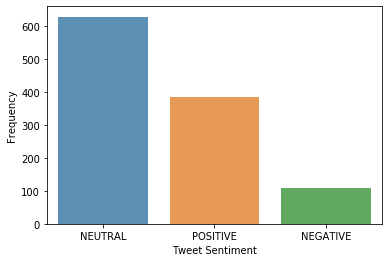

In [249]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_count = tweets['sentiment'].value_counts()
print(sentiment_count)
sns.barplot(sentiment_count.index, sentiment_count.values, alpha=0.8)
plt.xlabel('Tweet Sentiment'); plt.ylabel('Frequency')
plt.show()

## Create word clouds

### Get list of words from all tweets

In [250]:
tweets_words = tweets['text'].tolist()

### Get list of words from positive tweets

In [251]:
positive_tweets = tweets.loc[(tweets['sentiment'] == Sentiment.POSITIVE)]
positive_tweets.head()

positive_tweets_words = positive_tweets['text'].tolist()
print(positive_tweets_words[0:5])

,time,place,text,sentiment
1,"(4, 2020)",NaN,friends! girl hosting happy hour party tonight...,POSITIVE
3,"(4, 2020)",Japan,friends! girl hosting happy hour party tonight...,POSITIVE
8,"(4, 2020)",Somewhere out there,friends! girl hosting happy hour party tonight...,POSITIVE
11,"(4, 2020)",NaN,somers first responder zoom discussion cocktai...,POSITIVE
12,"(4, 2020)",NaN,q2 zoom houseparty webex skype gal. love zoom ...,POSITIVE


['friends! girl hosting happy hour party tonight zoom. go. laugh. drink eat, or…', 'friends! girl hosting happy hour party tonight zoom. go. laugh. drink eat, or…', 'friends! girl hosting happy hour party tonight zoom. go. laugh. drink eat, or…', 'somers first responder zoom discussion cocktail party imbibing aviation gin', 'q2 zoom houseparty webex skype gal. love zoom yoga class zoom cocktail party house…']


### Get list of words from negative tweets

In [252]:
negative_tweets = tweets.loc[(tweets['sentiment'] == Sentiment.NEGATIVE)]
negative_tweets.head()

negative_tweets_words = negative_tweets['text'].tolist()
print(negative_tweets_words[0:5])

,time,place,text,sentiment
9,"(4, 2020)",NaN,fam said i’m party animal it’s 9:30 quarantine...,NEGATIVE
13,"(4, 2020)","Misplaced Kentuckian, SC",found new game came make u drink. weekend zoom...,NEGATIVE
15,"(4, 2020)",NaN,"zoom party uncle, &amp; forced drink. told pra...",NEGATIVE
19,"(4, 2020)",Essex/London,never take seeing friend granted :( joe’s 21st...,NEGATIVE
21,"(4, 2020)",Essex/Kent,never take seeing friend granted :( joe’s 21st...,NEGATIVE


['fam said i’m party animal it’s 9:30 quarantine light off, sister getting drunk o…', 'found new game came make u drink. weekend zoom party?', 'zoom party uncle, &amp; forced drink. told practicing alcohol. got 3…', 'never take seeing friend granted :( joe’s 21st zoom cocktail party amazing want hug…', 'never take seeing friend granted :( joe’s 21st zoom cocktail party amazing want t…']


### Create word cloud (wc) from the lists of words

Note: 
* I'm removing "zoom" & "party" from the display as they give no new info, due to their prevalence in both positive & negative tweets.
* I'm also setting collocations to False, so as to remove word duplicates.

In [253]:
from wordcloud import WordCloud,STOPWORDS

def wordcloud_draw(data, color = 'black'):
    stopwords = set(STOPWORDS)
    stopwords.add("zoom"); stopwords.add("party")
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=stopwords,
                          collocations=False,
                          background_color=color,
                          width=2500,
                          height=2000
                          ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

#### WC of all tweets

Word Cloud of all tweets


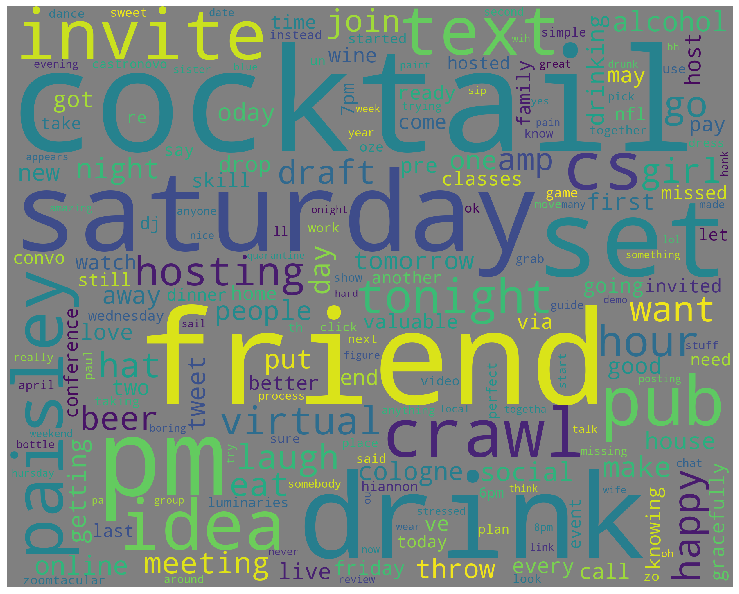

In [254]:
print("Word Cloud of all tweets")
wordcloud_draw(tweets_words,'grey')

#### WC of positive tweets

Word Cloud of positive tweets


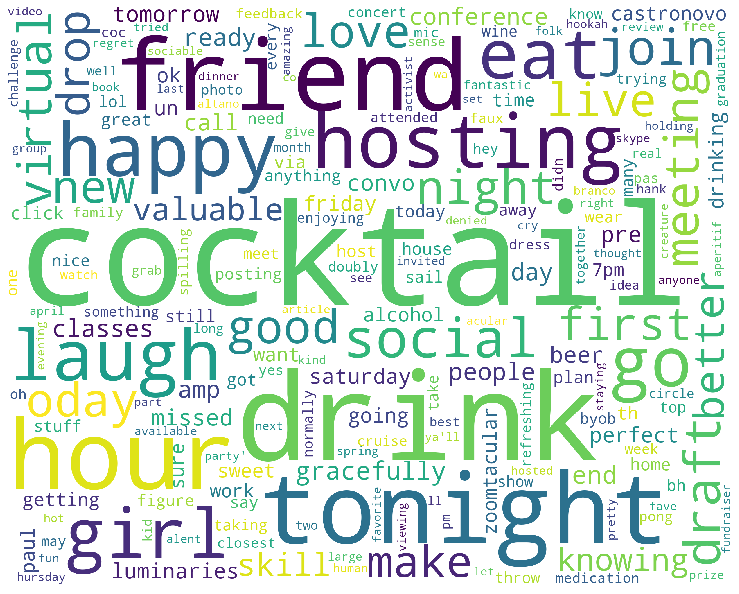

In [255]:
print("Word Cloud of positive tweets")
wordcloud_draw(positive_tweets_words,'white')

#### WC of negative tweets

Word Cloud of negative tweets


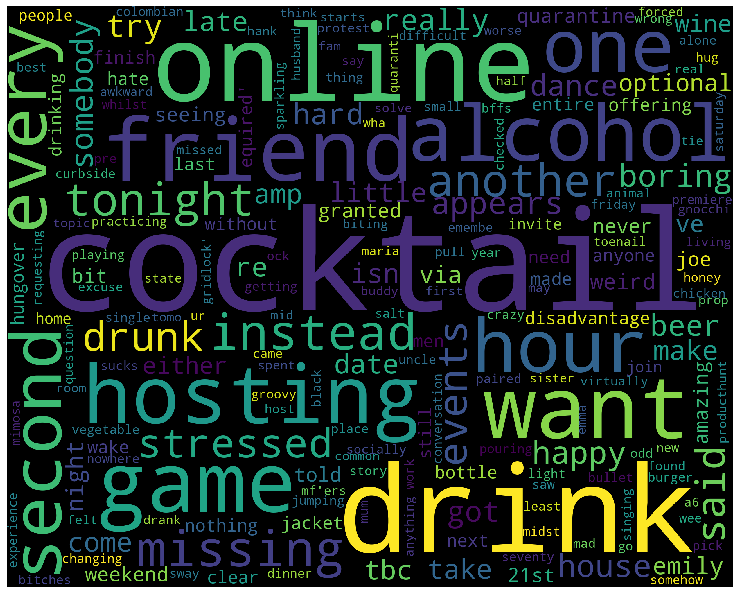

In [256]:
print("Word Cloud of negative tweets")
wordcloud_draw(negative_tweets_words,'black')